In [1]:
'''
Analyze power efficiency based on laser displacement measurement
Author: Yitian Shao
Created on 2023.01.03
'''

import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import mlab
import pandas as pd
import scipy.io as scio
from scipy import signal
import seaborn as sns

plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rcParams['lines.linewidth'] = 1.125
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['errorbar.capsize'] = 4

figSize_inch = (3.2, 2.4)

''' Define Color Here '''
pltBlue = (32/255,120/255,180/255)
pltRed = (180/255,32/255,32/255)

''' Remove warnings '''
import warnings
warnings.filterwarnings('ignore')


In [2]:
def aPlot(figName='', is3D = False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize = (6,3), dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if(is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def lowpassSmooth(datain, cutFreqRatio = 0.05, order = 8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def decodeData(fileName, numFormat, frontCode='', rearCode='', isString=False):
    segStr = re.findall(frontCode+numFormat+rearCode, fileName)
    if segStr:
        if isString:
            return segStr[0]
        else:
            numData = float(re.findall(numFormat, segStr[0])[0])
    else:
        numData = None
    return numData

In [3]:
'''
Load and preprocess displacement, voltage, current data
'''
def loadAndProcessData(measureDataPath, disp=True):

    # Parameter of Trek 610E High Voltage Amplifier (Should not be changed)
    VoltageScaleFactor = 1.0 # (1V monitor voltage = 1kV actual voltage)
    CurrentScaleFactor = 0.2 # (1V monitor voltage = 0.2mA actual current)

    Fs = None 
    laserData = []

    ''' Data preprocess '''
    for root, directories, files in walk(measureDataPath):
        for fileName in files:
            tubeLen = decodeData(fileName, '\d+', rearCode='mm')
            sinFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='Hz') 
            voltage = decodeData(fileName, '\d+', rearCode='kV') 
            loadWeight = decodeData(fileName, '\d+', rearCode='gr')

            trialNum = decodeData(fileName, '\d+', rearCode='.txt')
            if trialNum is None:
                trialNum = 1

            waveform = decodeData(fileName, 'pulse', isString=True)  # Data20221221
            if waveform is None:
                waveform = decodeData(fileName, 'sine', isString=True)  # Data20221221

            dLabel = ""
            if waveform is not None:
                dLabel = dLabel + waveform
            if tubeLen is not None:
                dLabel = dLabel + ("%dmm" % tubeLen)           
            if sinFreq is not None:
                dLabel = dLabel + ("%.1fHz" % sinFreq)
            if voltage is not None:
                dLabel = dLabel + ("%dkV" % voltage)
            if loadWeight is not None:
                dLabel = dLabel + ("%dgr" % loadWeight)
            print(dLabel)
            print(trialNum)

            readData = pd.read_csv(ospa.join(root, fileName), header = None)

            voltageData = None
            dispData = None
            currentData = None
            if readData is not None:       
                t = readData[0].to_numpy(dtype='float64')
                diffT = np.diff(t)
                diffT = diffT[diffT > 0]
                SampleRate = int(1.0/np.mean(diffT))
                if SampleRate != Fs:
                    if Fs is None:
                        Fs = SampleRate
                        print("Sampling frequenecy = %.2f Hz" % Fs)
                    else:
                        print("Sampling frequenecy of current data %.2fHz differs from the Fs = %.2f Hz" % (SampleRate, Fs))

                voltageData = readData[1].to_numpy(dtype='float64') * VoltageScaleFactor
                dispData = readData[2].to_numpy(dtype='float64')
                currentData = readData[3].to_numpy(dtype='float64') * CurrentScaleFactor

#                 smCurrent = lowpassSmooth(currentData, cutFreqRatio = (10/Fs), order = 10)

                t = np.arange(voltageData.shape[0])/Fs;
    #             ind = (t > 0.7) & (t < 11.0) # Use data from ? sec to ? sec only!
                ind = np.arange(voltageData.shape[0])

                if disp: 
                    _,ax = plt.subplots(2,2,dpi=72, figsize=(16,4))
                    ax[0][0].plot(t[ind], dispData[ind], color='tab:red')
                    ax1b = ax[0][0].twinx() 
                    ax1b.plot(t[ind], voltageData[ind], color='tab:grey'); 
                    ax[0][0].set_ylabel('mm', color='tab:red')
                    ax1b.set_ylabel('kV', color='tab:grey')

                    ax[0][1].plot(t[ind], currentData[ind], color='tab:blue')
#                     ax[0][1].plot(t[ind], smCurrent[ind], color='tab:green')
                    ax[0][1].set_ylabel('mA - raw (blue) / Lowpass (green)')


#                     ax[1][0].plot(t[ind], voltageData[ind], color='tab:grey');
#                     ax[1][0].set_ylabel('Voltage (kV)', color='tab:grey')
#                     ax3b = ax[1][0].twinx() 
# #                     ax3b.plot(t[ind], smCurrent[ind], color='tab:green');
#                     ax3b.set_ylabel('Smoothed Current (mA)', color='tab:green')

                    ax[1][1].plot(t[ind], voltageData[ind], color='tab:grey');
                    ax4b = ax[1][1].twinx() 
                    ax4b.plot(t[ind], currentData[ind], color='tab:blue');
                    ax4b.set_ylabel('Raw Current (mA)', color='tab:blue')

                    plt.show();

            laserData.append([dLabel, waveform, tubeLen, sinFreq, voltage, loadWeight, voltageData[ind], dispData[ind], currentData[ind], int(trialNum)])

    laserData = pd.DataFrame(laserData, columns = ['Label', 'Waveform', 'TubeLength_mm', 'SinFreq_Hz', 'Voltage_kV', 'Load_gram',
                                                   'VoltageData_kV', 'DisplData_mm', 'CurrentData_mA', 'TrialNum'])  

    return laserData, Fs

pulse60mm0.2Hz7kV100gr
3.0
Sampling frequenecy = 989.00 Hz


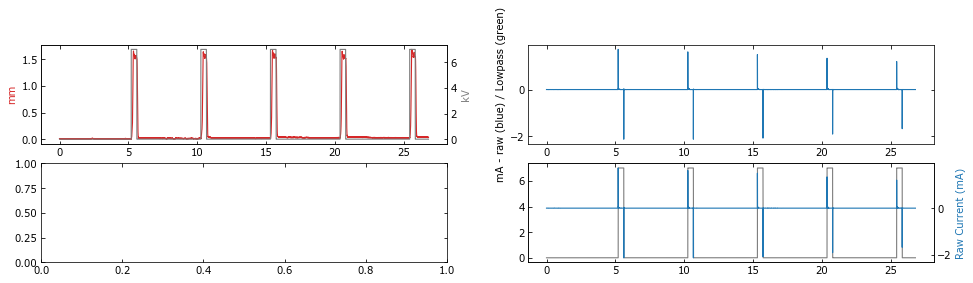

pulse60mm0.2Hz7kV100gr
4.0


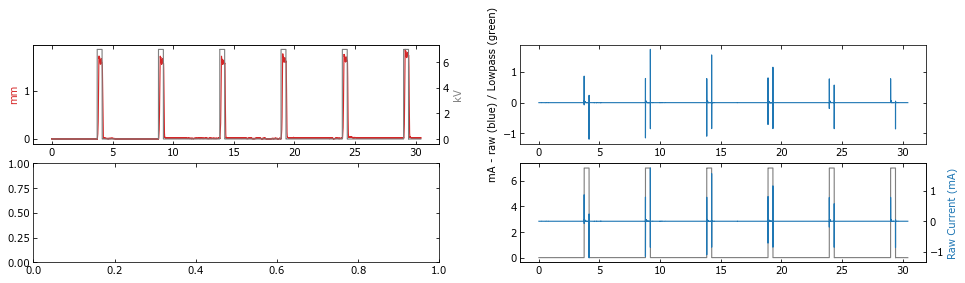

pulse60mm0.2Hz7kV100gr
5.0


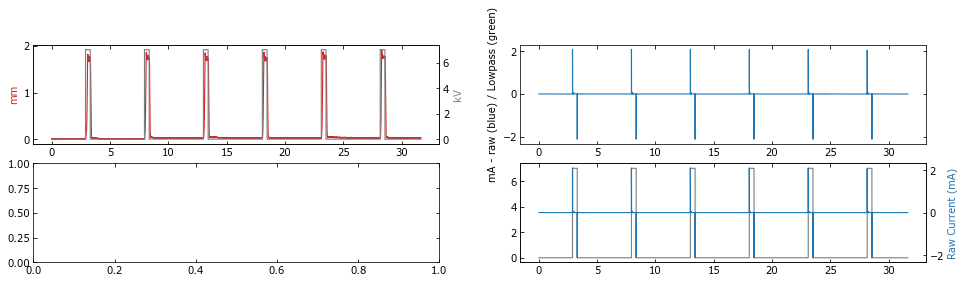

pulse60mm0.2Hz7kV100gr
6.0


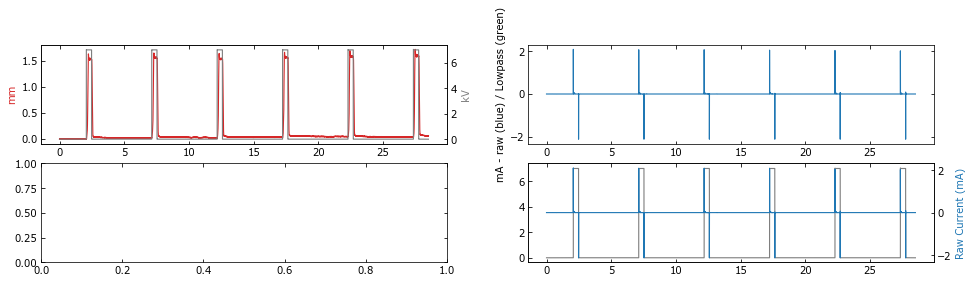

pulse60mm0.2Hz7kV50gr
1.0


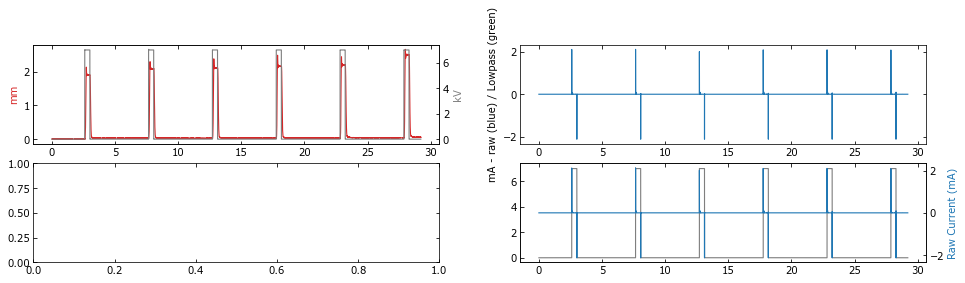

pulse60mm0.2Hz7kV50gr
2.0


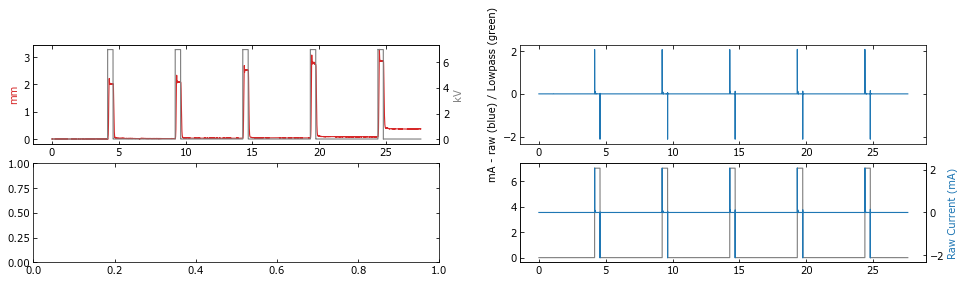

,Label,Waveform,TubeLength_mm,SinFreq_Hz,Voltage_kV,Load_gram,VoltageData_kV,DisplData_mm,CurrentData_mA,TrialNum
0,pulse60mm0.2Hz7kV100gr,pulse,60.0,0.2,7.0,100.0,"[0.0012, 0.0022, 0.0019, 0.0009, -0.0001, 0.00...","[0.0098, 0.0098, 0.0088, 0.0104, 0.0075, 0.008...","[0.00058, -0.00028000000000000003, 4e-05, -2e-...",3
1,pulse60mm0.2Hz7kV100gr,pulse,60.0,0.2,7.0,100.0,"[0.0012, 0.0009, 0.0006, 0.0009, 0.0002, -0.00...","[-0.0014, -0.0001, 0.0002, -0.0014, -0.0034, -...","[0.00038, 0.00030000000000000003, 0.0009599999...",4
2,pulse60mm0.2Hz7kV100gr,pulse,60.0,0.2,7.0,100.0,"[-0.0001, 0.0009, 0.0019, 0.0002, 0.0009, 0.00...","[0.0101, 0.0098, 0.0107, 0.0121, 0.0101, 0.013...","[0.00018, 0.00030000000000000003, 0.00018, 0.0...",5
3,pulse60mm0.2Hz7kV100gr,pulse,60.0,0.2,7.0,100.0,"[0.0012, 0.0019, 0.0015, 0.0009, -0.0001, 0.00...","[-0.0021, -0.0008, -0.0044, -0.0014, -0.0021, ...","[0.00011999999999999999, 0.0003000000000000000...",6
4,pulse60mm0.2Hz7kV50gr,pulse,60.0,0.2,7.0,50.0,"[0.0009, 0.0012, 0.0012, -0.0001, 0.0009, 0.00...","[0.0038, 0.0038, 0.0025, 0.0025, 0.0032, 0.001...","[-0.00016, 0.00011999999999999999, -2e-05, -8e...",1
5,pulse60mm0.2Hz7kV50gr,pulse,60.0,0.2,7.0,50.0,"[0.0009, 0.0015, 0.0015, 0.0015, 0.0006, -0.00...","[0.0045, 0.0048, 0.0038, 0.0042, 0.0048, 0.002...","[0.00044000000000000007, 0.00038, 0.0002399999...",2


In [4]:
''' Import and Merge Data '''
measureDataPath0 = './PowerData20221221'
measureDataPath1 = './PowerData20230110'
################## measureDataPath = './PowerData20230113'

laserData,Fs = loadAndProcessData(measureDataPath1, disp=True)
# laserData,Fs = loadAndProcessData(measureDataPath0, disp=True)
# laserData = pd.concat([laserData.loc[laserData['Waveform']=='pulse'], tmpLaserData], axis=0, ignore_index=True, sort=False)
display(laserData)

In [5]:
'''
Compute mechanical power output and electrical power consumption: Pulse
'''
def plotPowerData(ax0, ax1, ax1b, t, displacement, voltage, current, ylabel0=''):
    # Show the complete signals
    ax0.plot(t, displacement, '-', color='#FFD0D0')
    ax1.plot(t, voltage, '-', color='#D0D0D0')
    ax1b.plot(t, current, '-', color='#D0FFD0')

    # X-axis labels
    ax0.set_xlabel('Time (sec),  Weight-lifting Time: ')
    # Y-axis labels
    ax0.set_ylabel(ylabel0 + '\nDisplacement (m)')
    ax1.set_ylabel('Voltage (V)', color='tab:grey')
    ax1b.set_ylabel('Current (A)', color='tab:green')

def segLiftingPhase(rowData, segNum, displThreshold_m=0.0005):
    loadForce = rowData["Load_gram"] * 9.8e-3 # Converted to SI Unit (N)
    voltage = rowData["VoltageData_kV"] * 1.0e3 # Converted to SI Unit (V)
    displacement = rowData["DisplData_mm"] * 1.0e-3 # Converted to SI Unit (m)
    current = rowData["CurrentData_mA"] * 1.0e-3 # Converted to SI Unit (A)
    t = np.arange(voltage.shape[0])/Fs

    chargingInd = np.where(np.diff(displacement) > 0)[0] # Only use segment of data in weight-lifting phase

    tmp = np.where(np.diff(displacement[chargingInd]) < -displThreshold_m)[0]
    segEnd = chargingInd[tmp[1:]]+1 # End of a segment (index+1)
    segStart = chargingInd[tmp[:-1]+1] # Start of a segment

    segEnd = segEnd[:segNum]
    segStart = segStart[:segNum]

    return segStart, segEnd, loadForce, displacement, voltage, current, t

def computePower(i0, i1, loadForce, displacement, voltage, current, t, Fs, ActuatorWeight, disp=True, dispMarker=False):
    i0 = np.where(voltage[i0:i1] > 500)[0][0] + i0
    i1 = np.argmax(displacement[i0:i1]) + i0

    dT = 1/Fs
    segT = t[i1] - t[i0]

    segVoltage = voltage[i0:i1]
    segCurrent = current[i0:i1]

    # Mechanical power output (W, consider only the gravitational potential energy)
    pEnergy = (displacement[i1] - displacement[i0]) * loadForce
    pM = pEnergy / segT

    # Electrical power consumption (W)
    pE = (np.sum(np.multiply(segVoltage, segCurrent)) * dT) / segT

    # Ratio between power output and input
    pR = pM/pE

    # Energy to weight ratio (J/kg)
    pEnW = pEnergy / ActuatorWeight

    # Power to weight ratio (W/kg)
    pPoW = pM / ActuatorWeight

    if disp:
        # Visualize data segments
        ax[0].plot(t[i0:i1], displacement[i0:i1], color='tab:red')
        if dispMarker:
            ax[0].plot(t[i1], displacement[i1], '*',color='tab:orange') # Mark the end of displacement (peak) 
            ax[0].plot(t[i0], displacement[i0], '*',color='tab:green') # Mark the start of displacement
        ax[1].plot(t[i0:i1], segVoltage, color='tab:grey')
        ax1b.plot(t[i0:i1], segCurrent, color='tab:green') 

        ax[0].set_xlabel(ax[0].get_xlabel() + ("%.3f " % segT))

    return pM, pE, pR, pEnW, pPoW
        
ActuatorWeight = 1.255*1e-3 # (kg)

segNum = 8 # Number of valid segments (8)

['pulse60mm0.2Hz7kV100gr' 'pulse60mm0.2Hz7kV50gr']
pulse60mm0.2Hz7kV100gr_3 - Pmech = 0.010235 W [+/-0.000767], Pelec = 0.174512 W [+/-0.015435], Ratio = 5.9 %
Energy-weight Ratio = 1.3 J/kg [+/-0.012733], Power-weight Ratio = 8.2 W/kg [+/-0.611015]
pulse60mm0.2Hz7kV100gr_4 - Pmech = 0.011980 W [+/-0.000776], Pelec = 0.129175 W [+/-0.027284], Ratio = 9.5 %
Energy-weight Ratio = 1.4 J/kg [+/-0.037279], Power-weight Ratio = 9.5 W/kg [+/-0.618625]
pulse60mm0.2Hz7kV100gr_5 - Pmech = 0.012813 W [+/-0.000874], Pelec = 0.209810 W [+/-0.009507], Ratio = 6.1 %
Energy-weight Ratio = 1.4 J/kg [+/-0.018350], Power-weight Ratio = 10.2 W/kg [+/-0.696322]
pulse60mm0.2Hz7kV100gr_6 - Pmech = 0.010893 W [+/-0.000860], Pelec = 0.190288 W [+/-0.007278], Ratio = 5.7 %
Energy-weight Ratio = 1.3 J/kg [+/-0.017072], Power-weight Ratio = 8.7 W/kg [+/-0.685415]
pulse60mm0.2Hz7kV50gr_1 - Pmech = 0.010848 W [+/-0.000715], Pelec = 0.287629 W [+/-0.007338], Ratio = 3.8 %
Energy-weight Ratio = 0.9 J/kg [+/-0.045842]

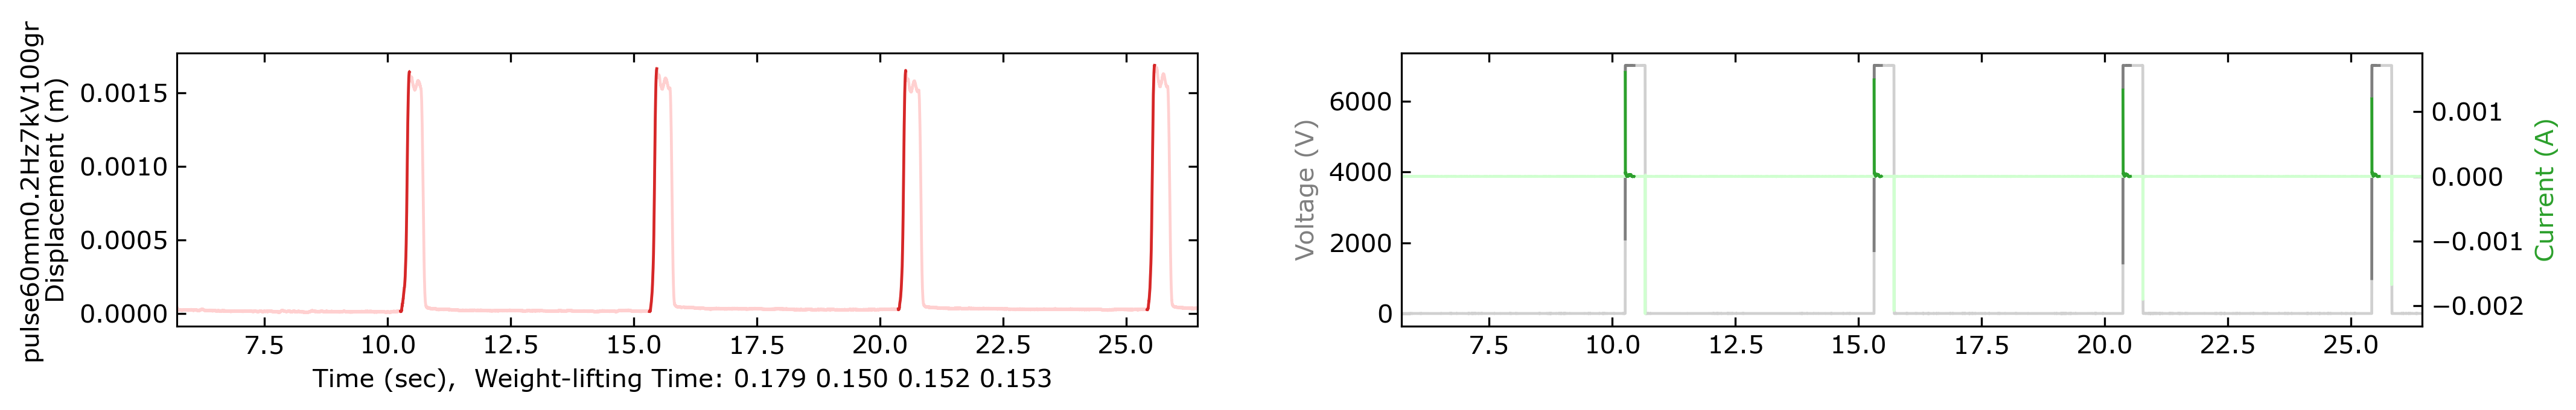

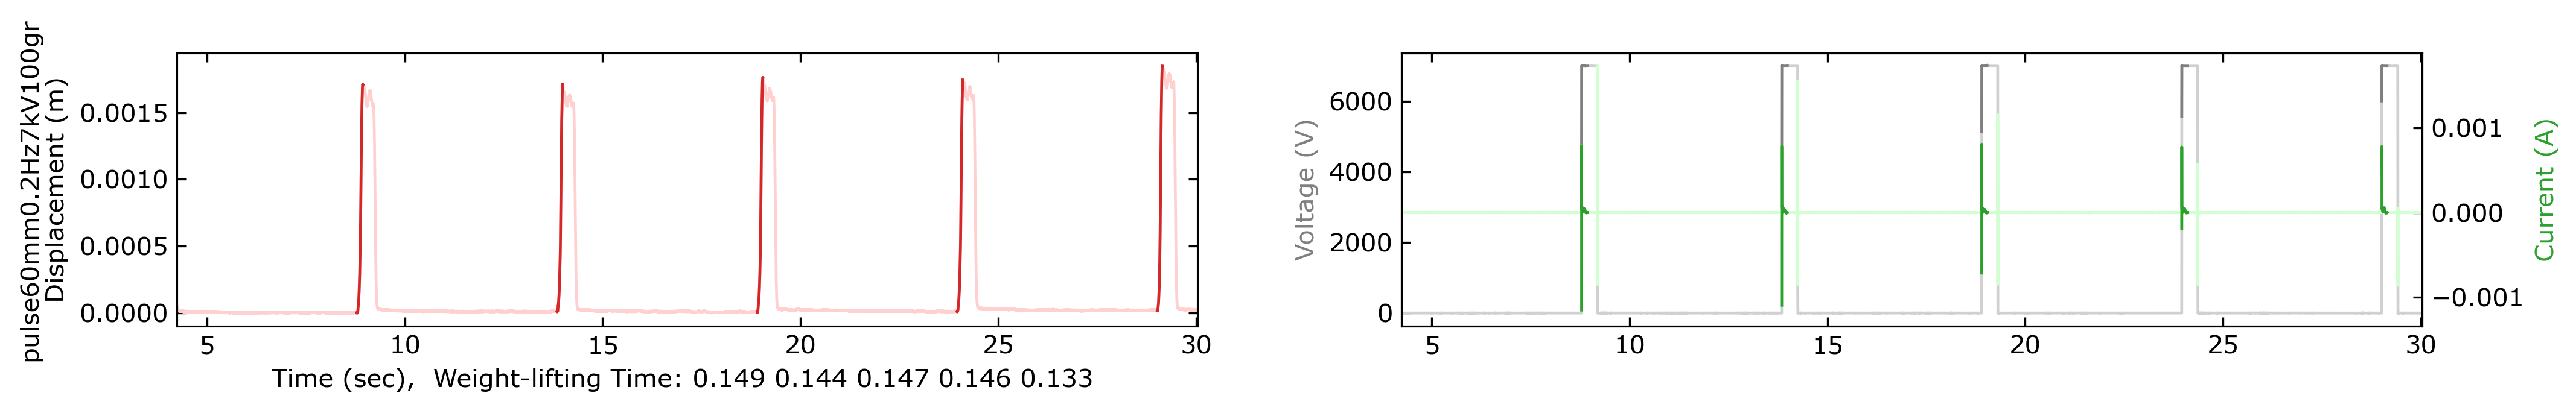

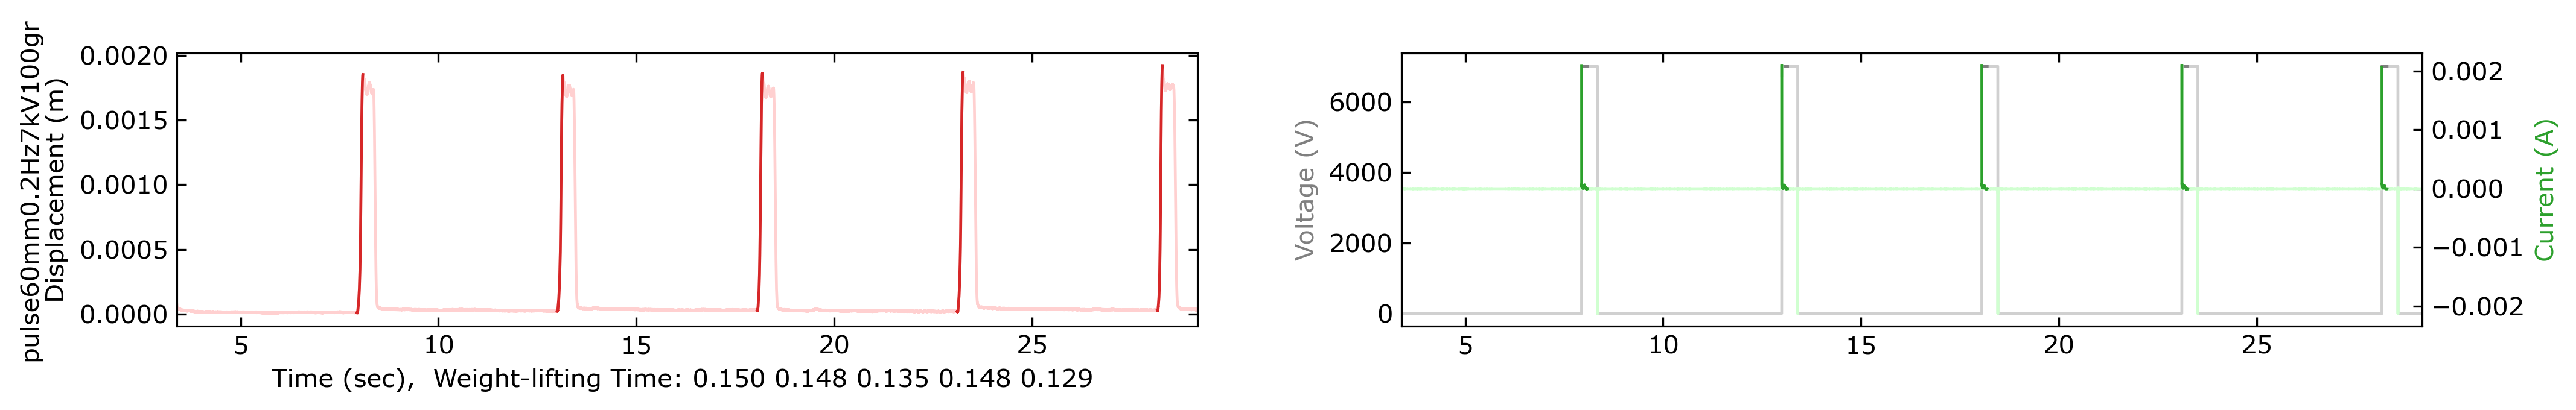

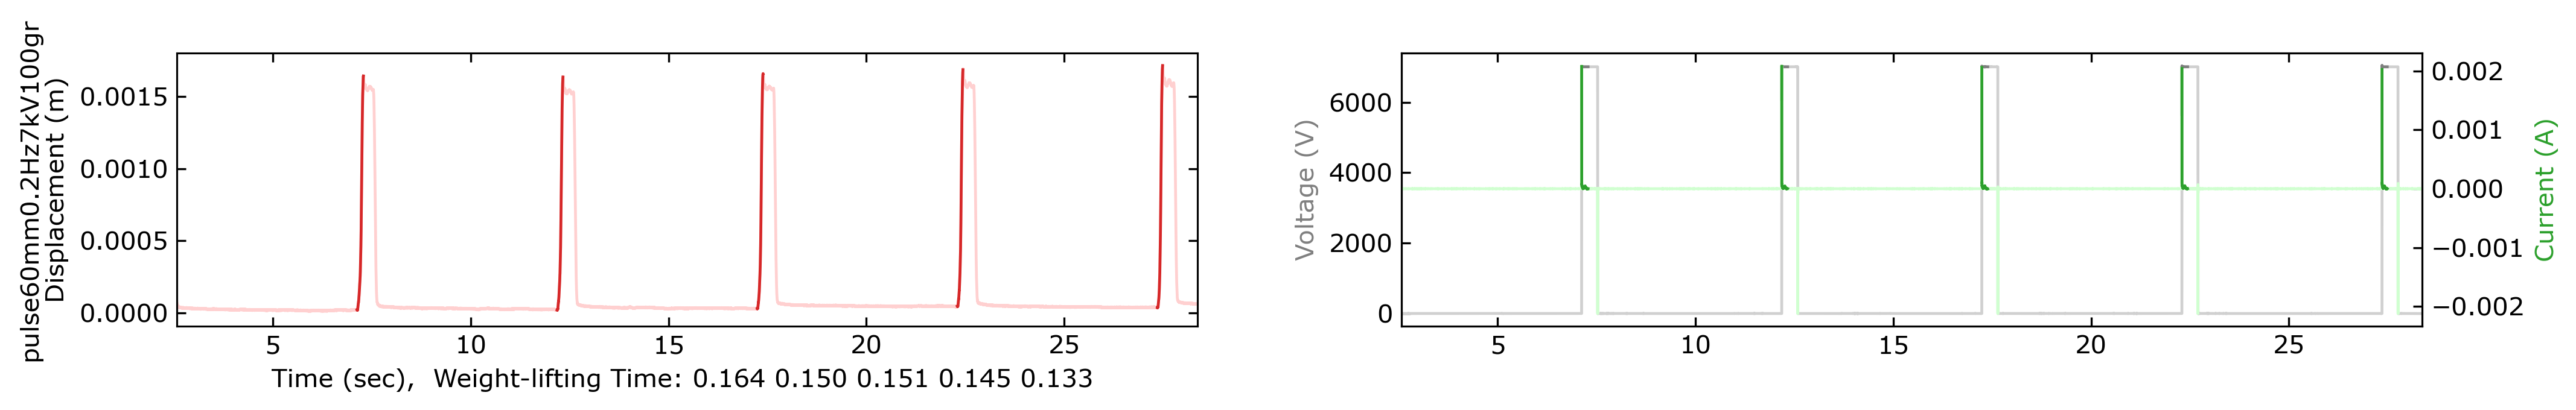

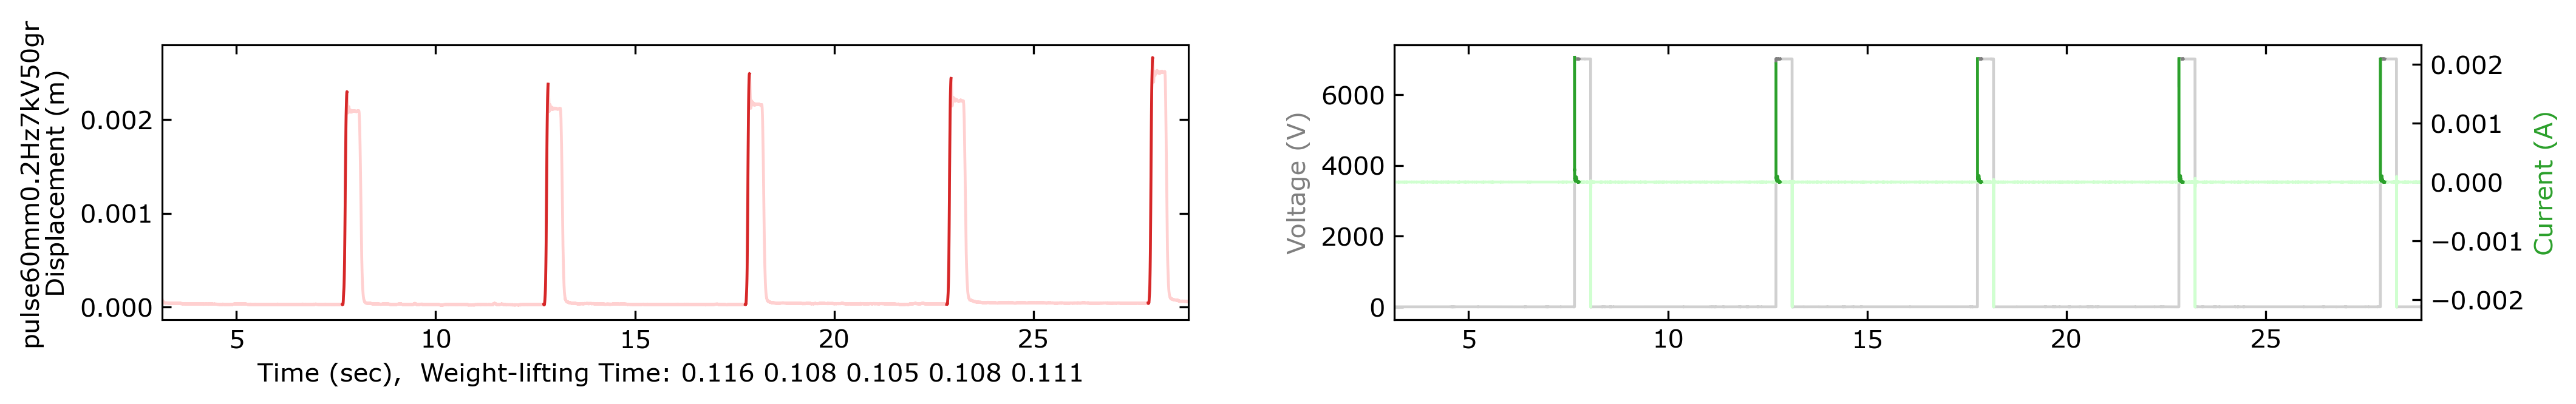

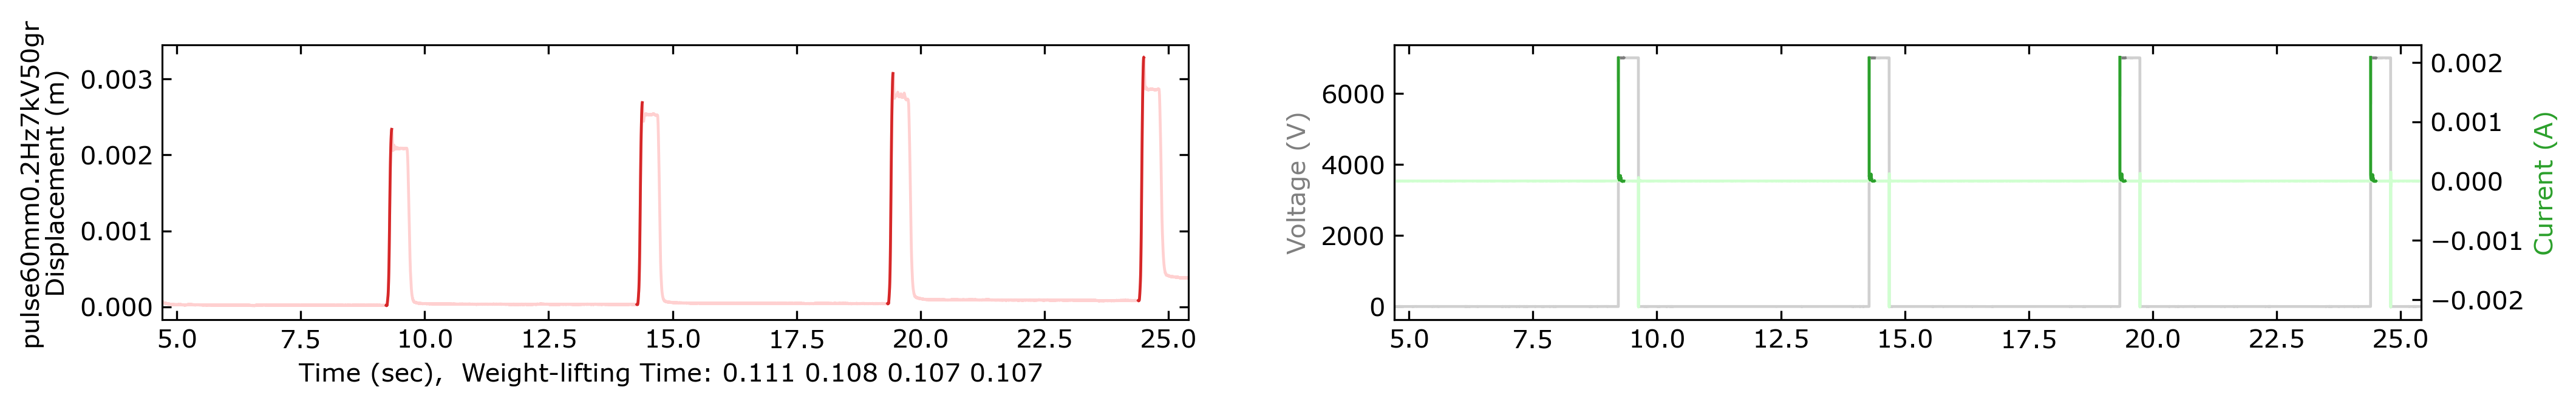

In [6]:
''' All Power Evaluation Results '''
labels = laserData.Label.unique()
print(labels)

powerData = []

for aLabel in labels:
    selectedData = laserData.loc[(laserData['Label'] == aLabel)]
   
    for index, row in selectedData.iterrows():
        if row["Waveform"] == 'pulse' and row["Load_gram"] > 0:
            segStart, segEnd, loadForce, displacement, voltage, current, t = segLiftingPhase(row, segNum)

            # Plot data segmentation
            fig1,ax = plt.subplots(1,2,dpi=300, figsize=(16,2))
            ax1b = ax[1].twinx()
            plotPowerData(ax[0], ax[1], ax1b, t, displacement, voltage, current, ylabel0=row["Label"])
           
            pMech = []
            pElec = []
            pRatio = []
            pEnergyRatio = []
            pPowerRatio = []    
            for i0, i1 in zip(segStart, segEnd):
                pM, pE, pR, pEnW, pPoW = computePower(i0, i1, loadForce, displacement, voltage, current, t, Fs, ActuatorWeight)
               
                pMech.append(pM) # Mechanical power output (W)
                pElec.append(pE) # Electrical power consumption (W)
                pRatio.append(pR) # Ratio between power output and input
                pEnergyRatio.append(pEnW) # Energy to weight ratio (J/kg)
                pPowerRatio.append(pPoW) # Power to weight ratio (W/kg)

            xAxisLim = [t[segStart[0]], t[segEnd[-1]]+0.6]
            ax[0].set_xlim(xAxisLim)
            ax[1].set_xlim(xAxisLim)
    
            print("%s_%d - Pmech = %.6f W [+/-%.6f], Pelec = %.6f W [+/-%.6f], Ratio = %.1f %%" % (row["Label"], 
                row["TrialNum"], np.mean(pMech), np.std(pMech), np.mean(pElec), np.std(pElec), np.mean(pRatio) * 100))
            print("Energy-weight Ratio = %.1f J/kg [+/-%.6f], Power-weight Ratio = %.1f W/kg [+/-%.6f]" % 
                  (np.mean(pEnergyRatio), np.std(pEnergyRatio), np.mean(pPowerRatio), np.std(pPowerRatio)))
            
            pMech = np.array(pMech)
            pElec = np.array(pElec)
            pRatio = np.array(pRatio)
            pEnergyRatio = np.array(pEnergyRatio)
            pPowerRatio = np.array(pPowerRatio) 
            
            powerData.append([row["Label"], row["TrialNum"], pMech, pElec, pRatio, pEnergyRatio, pPowerRatio])
            
            if(row['Load_gram']==10):
                fig1.savefig("%s.pdf" % row["Label"], bbox_inches='tight')
                             
powerData = pd.DataFrame(powerData, columns=['Label', 'TrialNum', 'MechPower_W', 'ElecPower_W', 'MERatio',
                                               'EnergyWeightRatio_J/kg', 'PowerWeightRatio_W/kg'])
# laserData = laserData.merge(powerData, how='left', on='Label')
# display(laserData)

,Label,Waveform,TubeLength_mm,SinFreq_Hz,Voltage_kV,Load_gram,VoltageData_kV,DisplData_mm,CurrentData_mA,TrialNum
1,pulse60mm0.2Hz7kV100gr,pulse,60.0,0.2,7.0,100.0,"[0.0012, 0.0009, 0.0006, 0.0009, 0.0002, -0.00...","[-0.0014, -0.0001, 0.0002, -0.0014, -0.0034, -...","[0.00038, 0.00030000000000000003, 0.0009599999...",4


pulse60mm0.2Hz7kV100gr_4.241sec - Pmech = 11.30 mW, Pelec = 108.29 mW, Ratio = 10.4 %
Energy-weight Ratio = 1.338 J/kg, Power-weight Ratio = 9.0 W/kg
pulse60mm0.2Hz7kV100gr_9.302sec - Pmech = 11.63 mW, Pelec = 107.13 mW, Ratio = 10.9 %
Energy-weight Ratio = 1.331 J/kg, Power-weight Ratio = 9.3 W/kg
pulse60mm0.2Hz7kV100gr_14.360sec - Pmech = 11.75 mW, Pelec = 116.40 mW, Ratio = 10.1 %
Energy-weight Ratio = 1.373 J/kg, Power-weight Ratio = 9.4 W/kg
pulse60mm0.2Hz7kV100gr_19.412sec - Pmech = 11.71 mW, Pelec = 133.73 mW, Ratio = 8.8 %
Energy-weight Ratio = 1.359 J/kg, Power-weight Ratio = 9.3 W/kg
pulse60mm0.2Hz7kV100gr_24.470sec - Pmech = 13.50 mW, Pelec = 180.32 mW, Ratio = 7.5 %
Energy-weight Ratio = 1.436 J/kg, Power-weight Ratio = 10.8 W/kg
pulse60mm0.2Hz7kV100gr Mean[+/-STD] - Pmech = 11.98 mW [+/-0.78], Pelec = 129.17 mW [+/-27.28], Ratio = 9.5 %


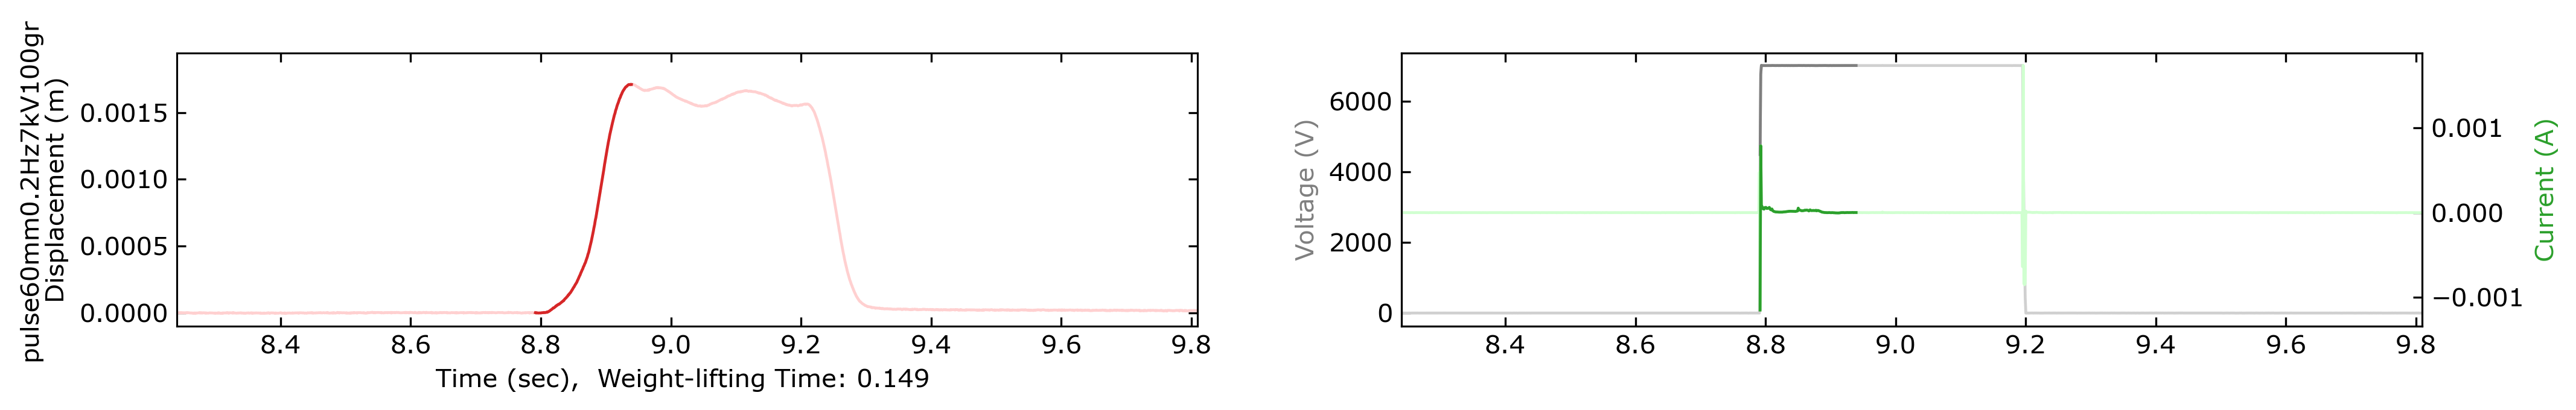

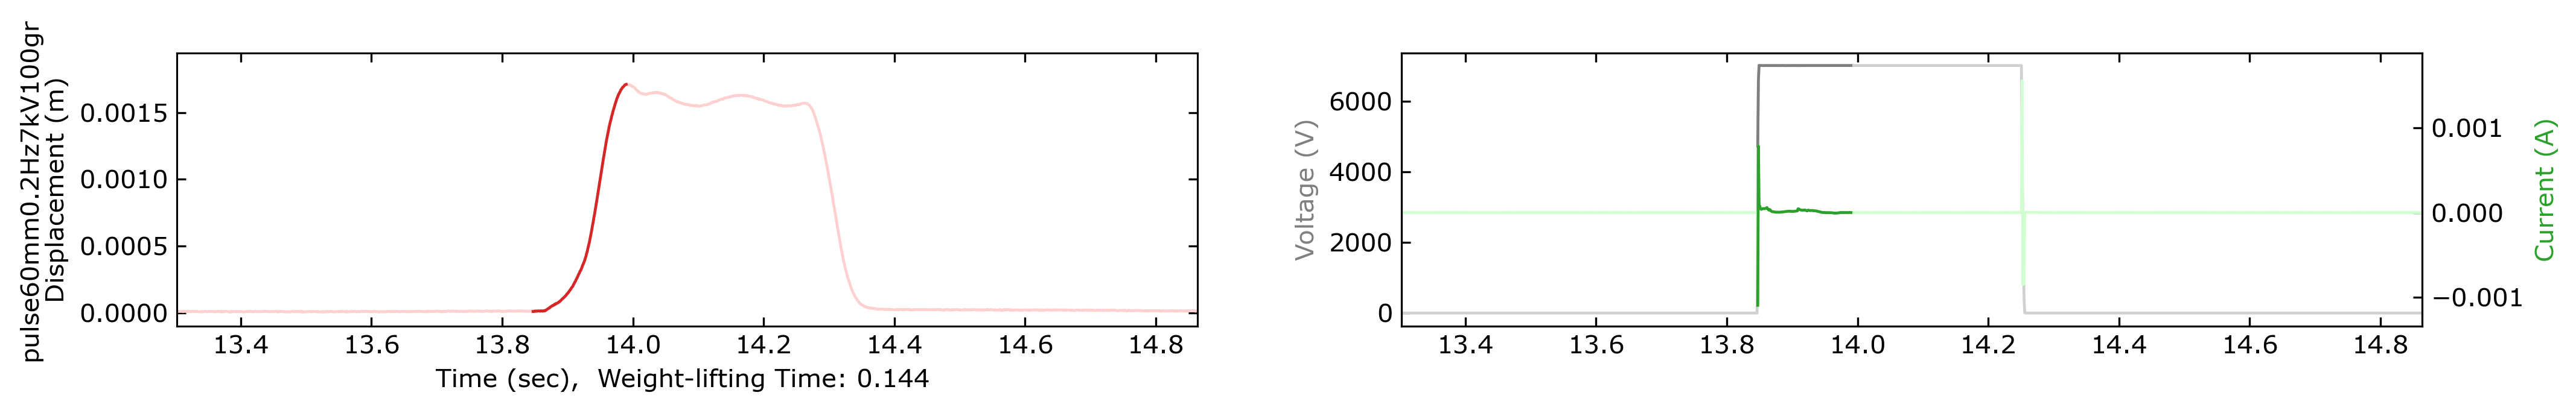

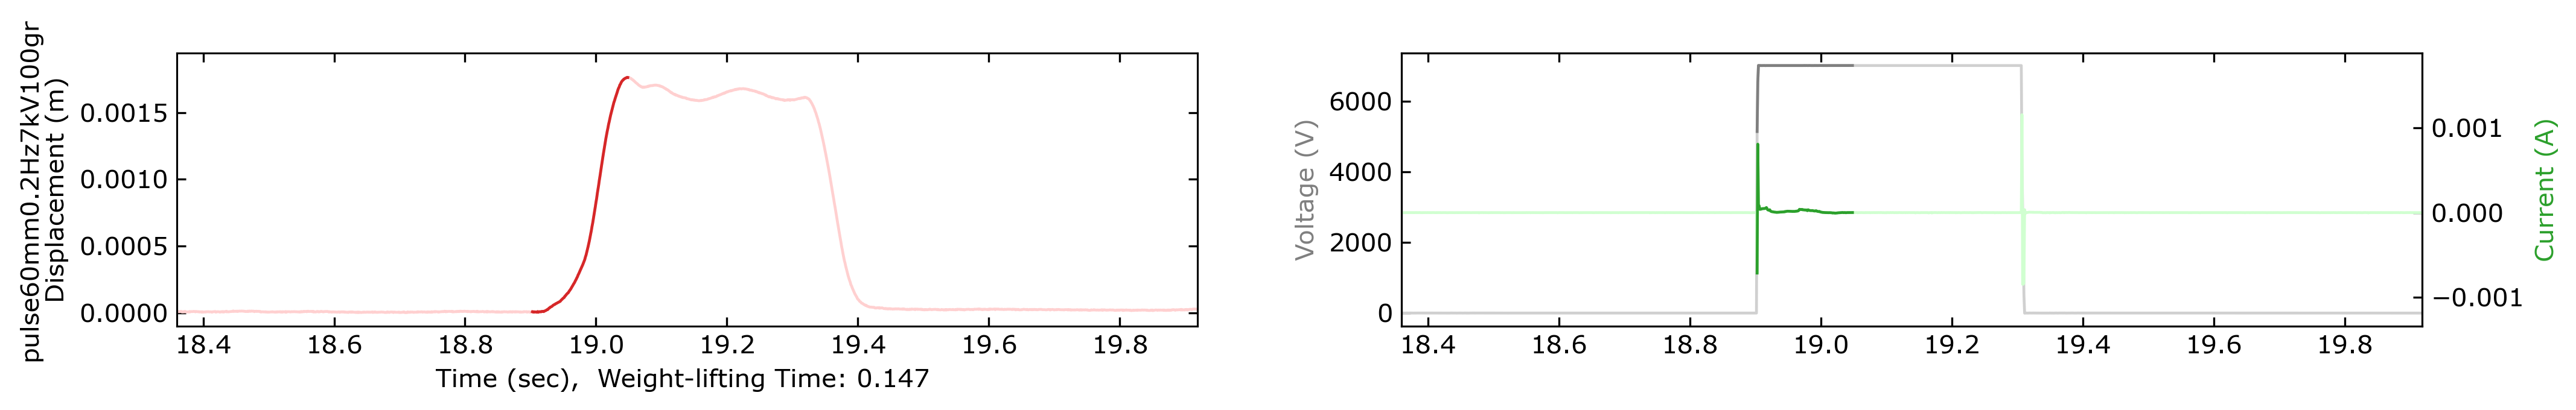

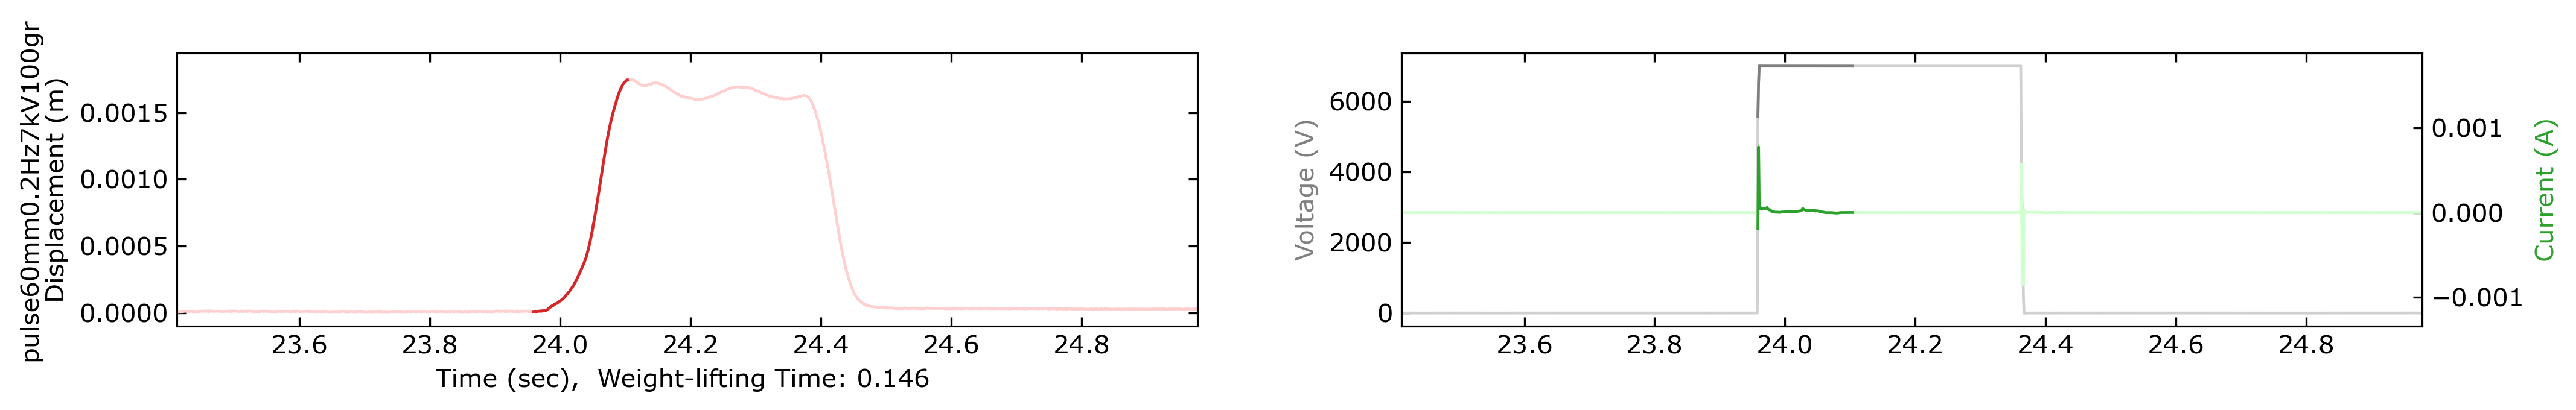

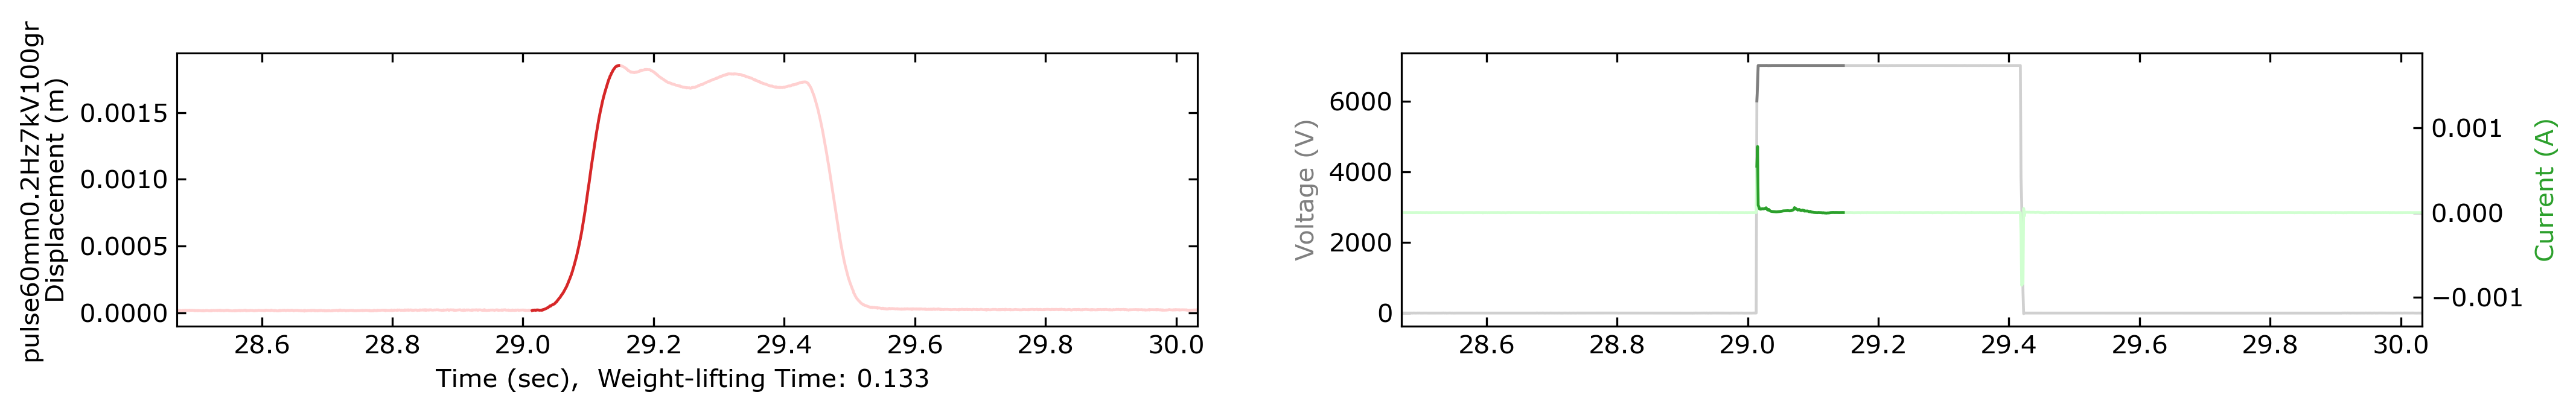

In [7]:
''' Plot detailed measurement '''
selectedData = laserData.loc[(laserData['Label'] == 'pulse60mm0.2Hz7kV100gr') & (laserData['TrialNum'] == 4)]
# selectedData = laserData.loc[(laserData['Label'] == 'pulse60mm1.0Hz3kV10gr')]
display(selectedData)

for index, row in selectedData.iterrows():
    if row["Waveform"] == 'pulse' and row["Load_gram"] > 0:
        segStart, segEnd, loadForce, displacement, voltage, current, t = segLiftingPhase(row, segNum)
           
        pMech = []
        pElec = []
        pRatio = []
        for i0, i1 in zip(segStart, segEnd):
            # Plot data segmentation
            fig2,ax = plt.subplots(1,2,dpi=300, figsize=(16,2))
            ax1b = ax[1].twinx()
            plotPowerData(ax[0], ax[1], ax1b, t, displacement, voltage, current, ylabel0=row["Label"])
            
            # Compute power
            pM, pE, pR, pEnW, pPoW = computePower(i0, i1, loadForce, displacement, voltage, current, t, Fs, ActuatorWeight)
                
            print("%s_%.3fsec - Pmech = %.2f mW, Pelec = %.2f mW, Ratio = %.1f %%" % (row["Label"], 
                t[i0], pM*1000, pE*1000, pR*100))
            print("Energy-weight Ratio = %.3f J/kg, Power-weight Ratio = %.1f W/kg" % (pEnW, pPoW))
            
            xAxisLim = [t[i0]+4, t[i1]+0.6] # ------------------------------------------ Set the xAxis limit here
#             xAxisLim = [t[i0], t[i1]+0.6] # ------------------------------------------ Set the xAxis limit here

            ax[0].set_xlim(xAxisLim)
            ax[1].set_xlim(xAxisLim)

            pMech.append(pM) # Mechanical power output (W)
            pElec.append(pE) # Electrical power consumption (W)
            pRatio.append(pR) # Ratio between power output and input
            
            fig2.savefig("%s_%.1fs.pdf" % (row["Label"], t[i0]), bbox_inches='tight')
   
        print("%s Mean[+/-STD] - Pmech = %.2f mW [+/-%.2f], Pelec = %.2f mW [+/-%.2f], Ratio = %.1f %%" % (row["Label"], 
            np.mean(pMech)*1e3, np.std(pMech)*1e3, np.mean(pElec)*1e3, np.std(pElec)*1e3, np.mean(pRatio) * 100))

In [ ]:
''' Plot power vs. driven voltage (Data only for 10gr measurement) '''
def getMeanSTD(compValue): # Compute errorbar of data mixing all conditions (rows of input array)
    if len(compValue) == 0:
        return None, None
        
    compValue = np.array(compValue)
    
    meanValue = np.mean(compValue)
    stdValue = np.std(compValue)
    
    return meanValue, stdValue

def computeErrorbar1Var(dframe, xColName, xColList, zColName):
    dMean = []
    dSTD = []
    
    for x in xColList:
        selectInd = (dframe[xColName] == x)

        compValue = dframe.loc[selectInd,zColName].values[0]

        valueMean, valueSTD = getMeanSTD(compValue)

        dMean.append(valueMean)
        dSTD.append(valueSTD)
    
    dMean = np.array(dMean)
    dSTD = np.array(dSTD)
    
    return dMean, dSTD

def dispErrorbar1VarPlot(dframe, xColName, xColList, zColName, ylabelName='', color='tab:orange', ax=None):
    meanMERatio, stdMERatio = computeErrorbar1Var(dframe, xColName, xColList, zColName)

    fig=None
    if ax is None:
        fig, ax = plt.subplots(dpi=300, figsize=(1,2))    
        
    for i in range(len(xColList)):
        ax.plot(xColList[i], meanMERatio[i], '.', color=color)
        ax.errorbar(xColList[i], meanMERatio[i], yerr=stdMERatio[i], fmt='none', ecolor=color, capsize=0)

    ax.set_ylabel(ylabelName, color=color)
    ax.set_xlabel(xColName)
    ax.set_xticks(xColList);
    
    ax.set_xlim([xColList[0]-0.5,xColList[-1]+0.5])
    
    return ax, fig

selectedData = laserData.loc[(laserData['Load_gram'] == 10)]
display(selectedData)

xLabel = 'Voltage_kV'
vLevels = np.array([3, 4, 5, 6, 7])

ax,fig3 = dispErrorbar1VarPlot(selectedData, xLabel, vLevels, 'MERatio', ylabelName='Efficiency', color='tab:orange')
ax.set_ylim([0, 0.04])
fig3.savefig("Compare_MERatio.pdf", bbox_inches='tight')

ax,fig3 = dispErrorbar1VarPlot(selectedData, xLabel, vLevels, 'PowerWeightRatio_W/kg', ylabelName='Power-Weight Ratio (W/kg)')
ax.set_ylim([0, 3.5])
fig3.savefig("Compare_PowerWeightRatio.pdf", bbox_inches='tight')


fig0,ax0 = plt.subplots(dpi=300, figsize=(2,2))   
ax0b = ax0.twinx()
dispErrorbar1VarPlot(selectedData, xLabel, vLevels, 'MechPower_W', ylabelName='Mechanical Power (W)', color='tab:red', 
                    ax=ax0)
dispErrorbar1VarPlot(selectedData, xLabel, vLevels, 'ElecPower_W', ylabelName='Electrical Power (W)', color='tab:green', 
                     ax=ax0b)
fig0.savefig("Compare_InputOutputPower.pdf", bbox_inches='tight')

In [ ]:
'''
Compute mechanical power output and electrical power consumption: Sine
'''

# labels = laserData.Label.unique()

# segNum = 8 # Number of valid segments

# dataFeature = []

# for aLabel in labels:
#     selectedData = laserData.loc[(laserData['Label'] == aLabel)]

#     pMechData = []
#     pElecData = []
    
#     for index, row in selectedData.iterrows():
#         if row["Waveform"] == 'sine' and row["Load_gram"] > 0:
#             loadForce = row["Load_gram"] * 9.8e-3 # Converted to SI Unit (N)
            
#             voltage = row["VoltageData_kV"] * 1.0e3 # Converted to SI Unit (V)
#             displacement = row["DisplData_mm"] * 1.0e-3 # Converted to SI Unit (m)
#             current = row["CurrentData_mA"] * 1.0e-3 # Converted to SI Unit (A)
#             t = np.arange(voltage.shape[0])/Fs

#             chargingInd = np.where(np.diff(displacement) > 0)[0] # Only use segment of data in weight-lifting phase
            
#             tmp = np.where(np.diff(displacement[chargingInd]) < -0.0005)[0]
#             segEnd = chargingInd[tmp[1:]]+1 # End of a segment (index+1)
#             segStart = chargingInd[tmp[:-1]+1] # Start of a segment
            
#             segEnd = segEnd[:segNum]
#             segStart = segStart[:segNum]

#             # Plot data segmentation
#             _,ax = plt.subplots(1,2,dpi=72, figsize=(16,2))
#             ax1b = ax[1].twinx()
            
#             # Show the complete signals
#             ax[0].plot(t, displacement, '--', color='#FFD0D0')
#             ax[1].plot(t, voltage, '--', color='#D0D0D0')
#             ax1b.plot(t, current, '--', color='#D0FFD0')
            
#             # X-axis labels
#             ax[0].set_xlabel("Time (sec),  Seg.T: ")
#             # Y-axis labels
#             ax[0].set_ylabel(row["Label"] + '\nDisplacement (m)')
#             ax[1].set_ylabel('Voltage (V)', color='tab:grey')
#             ax1b.set_ylabel('Current (A)', color='tab:green')
           
#             pMech = []
#             pElec = []
#             pRatio = []
#             for i0, i1 in zip(segStart, segEnd):
                
#                 i1 = np.argmax(displacement[i0:i1]) + i0
                    
#                 t_seg = t[i0:i1]
#                 dT = 1/Fs
#                 segT = t_seg[-1] - t_seg[0]
#                 segDisplacement = displacement[i0:i1]
#                 segVoltage = voltage[i0:i1]
#                 segCurrent = current[i0:i1]
                
# #                 vMax = np.max(np.diff(segDisplacement))/dT
                
# #                 print((0.5 * row["Load_gram"] * 1e-3 * (vMax * vMax)))
#                 # Mechanical power output (consider only the gravitational potential energy)
#                 pM = ((segDisplacement[-1] - segDisplacement[0]) * loadForce) / segT
                
#                 # Electrical power consumption
#                 pE = (np.sum(np.multiply(segVoltage, segCurrent)) * dT) / segT
                
#                 # Ratio between power output and input
#                 pR = pM/pE
                
#                 pMech.append(pM)
#                 pElec.append(pE)
#                 pRatio.append(pR)
                
#                 # Visualize data segments
#                 ax[0].plot(t_seg, segDisplacement, color='tab:red')
#                 ax[0].plot(t[i1], displacement[i1], '*',color='tab:orange')
#                 ax[0].plot(t[i0], displacement[i0], '*',color='tab:green')
                
#                 ax[1].plot(t_seg, segVoltage, color='tab:grey')
#                 ax1b.plot(t_seg, segCurrent, color='tab:green') 
                
#                 ax[0].set_xlabel(ax[0].get_xlabel() + ("%.2f " % segT))
                
#             pMech = np.array(pMech)    
#             pElec = np.array(pElec)      
#             pRatio = np.array(pRatio)      
#             print("%s - Pmech = %.6f W [+/-%.6f], Pelec = %.6f W [+/-%.6f], mean Ratio = %.1f %%" % (row["Label"], 
#                 np.mean(pMech), np.std(pMech), np.mean(pElec), np.std(pElec), np.mean(pRatio) * 100))
            
        